### 에지
에지란 영상의 명암, 컬러, 또는 텍스처와 같은 특성이 급격히 변하는 지점이다. 모든 에지 검출 알고리즘은 변화를 측정하고 변화량이 큰 곳을 에지로 취하는 원리를 따른다.  
변화량을 구하기 위해 보통 도함수(derivative)를 사용하는데, 컴퓨터 비전에서는 연속 공간이 아닌 이산 공간에서 정의된다. 따라서 이산 공간에서 도함수를 근사화하는 방법을 고안해야 한다.
$$
f'(x)=\frac{df}{dx} = \frac{f(x+\Delta x)-f(x)}{\Delta x}=f(x+1)-f(x)
$$

$$
\therefore mask= (-1,1)
$$
위와 같이 이에 해당하는 마스크는 (-1,1)이다. 마스크 연산이후 절대값이 임계값을 넘는 값을 에지 화소(edge pixel)라고 하고 이러한 마스크는 에지 마스크 또는 에지 연산자(edge operator)라고 한다.


### 에지 모델과 연산자
다음 그림은 계단 에지(step edge)와 램프 에지(ramp edge)라 불리는 두 종류의 에지를 가진 영상이다.
![](./data/step_and_ramp_edge.jpg)
그림의 c는 영상 f를 한 번 미분한 1차 도함수이고, d는 1차 도함수를 한 번 더 미분한 2차 도함수이다. 1차 미분을 살펴보면 계단 에지에서 봉우리(peak)가 나타난다. 봉우리의 두께가 1이므로 계단 에지만 존재하는 경우 에지를 찾는 일이 매우 간단하다.  
하지만 실제 데이터에서는 카메라로 영상을 획득할 때 완벽하게 초점을 맞추기 불가능하기 때문에 주로 램프 에지가 나타난다. 위 그림에서 7부터 10에 걸쳐 램프 에지가 나타나 두께가 4이다. 에지의 정확한 위치를 찾는 일을 위치 찾기(Localization)이라 한다.  
램프에지와 계단 에지 둘 모두에서 1차 미분 결과로 봉우리가 나타나고 2차 미분 결과에서  영교차(zero crossing)이 나타난 것을 볼 수 있다. 이렇게 봉우리와 영교차를 찾는것이 에지 검출의 기본원리이다.

에지 검출에서 고려해야 할 문제중 불완전한 광학 때문에 발생하는 잡음이 있다. 예를들어 실제로는 같은 명암이지만 이미지상에서 여러가지 요인으로 값이 조금씩 차이나는 문제이다. 그래서 에지 연산자를 적용하기 전, 잡음을 제거하기 위해 스무딩 연산을 적용하기도 한다.  
아래의 그림은 에지 검출에서 쓰는 여러가지 마스크이다.
![](./data/edge_mask.jpg)

이중 소벨 연산자(Sobel operator)와 프레윗 연산자(Prewitt operator)는 해당 픽셀의 아래와 윗 행까지 같이 고려한다. 즉, 스무딩 효과가 내포되어 있다. 소벨 연산자는 가까운 화소에 더 큰 가중치를 준다는 차이가 있다. 로버츠 연산자(Roberts operator)는 대칭이 아닐 뿐만 아니라 너무 작아 잘 사용하지 않고 소벨이 가장 널리 사용된다.

### 에지 강도와 에지 방향
그레디언트는 벡터이므로 에지 강도(edge magnitude(혹은 edge strength))와 에지 방향(edge direction)을 구할 수 있다. 다음 식은 그레디언트에서 에지 강도와 그레이언트 방향을 계산하는 식이다.
$$
Gradient : \Delta f =\begin{pmatrix} \frac{\partial f}{\partial y},\frac{\partial f}{\partial x} \end{pmatrix}=(d_{x},d_{y})
$$

$$
Edge \ Magnintude: S(y,x)=magnitude(\Delta f) = \sqrt{d_{y}^{2}+d_{x}^{2}}
$$

$$
Direction : D(y,x) = arctan(\frac{d_y}{d_x})
$$

에지 강도는 화소 (y,x)가 에지일 가능성 또는 신뢰도(confidence)를 나타내는 값이다.

### 코드구현
이번 구현은 그레이 스케일이미지에서 할 것이다.

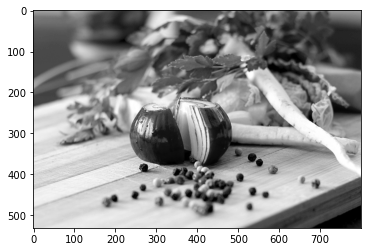

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img =cv2.cvtColor(cv2.imread('./data/food.jpg'),cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')
plt.show()

컨볼루션 연산은 이전에 구현한 im2col을 사용하자 [이전코드링크](https://github.com/Songminkee/computer_vision/blob/master/operation(point%2Carea%2Cgeometric).ipynb)  
이전과의 차이점은 gray scale 때의 처리를 추가하였고 return에서 int로 캐스팅 하지 않는다.

In [2]:
def im2col(input_data, filter_h, filter_w):
    H, W, C = input_data.shape

    u_pad_h = (filter_h-1)//2
    d_pad_h = (filter_h-1)//2
    l_pad_w = (filter_w-1)//2
    r_pad_w = (filter_w-1)//2
    if (filter_h-1) %2 ==1:
        u_pad_h +=1
    if (filter_w-1)%2 ==1:
        l_pad_w +=1
    input_data = cv2.copyMakeBorder(input_data, u_pad_h, d_pad_h, l_pad_w, r_pad_w, cv2.BORDER_REPLICATE)
    if C==1:
        input_data= np.expand_dims(input_data,-1)
    img = np.transpose(input_data,(2,0,1))
    col = np.zeros(( C, filter_h, filter_w, H, W))

    for y in range(filter_h):
        y_max = y + H
        for x in range(filter_w):
            x_max = x + W
            col[:, y, x, :, :] = img[:, y:y_max:1, x:x_max:1]

    col = np.transpose(col,(0,3,4,1,2)).reshape(C*H*W, -1)

    return col


def conv(img,filter):
    filter_h ,filter_w = filter.shape
    if len(img.shape) ==3:
        img_h,img_w,c = img.shape
    elif len(img.shape)==2:
        img_h,img_w = img.shape
        c=1
        img = np.expand_dims(img,-1)
    else:
        print("Length of image shape must over 2")
        return
    col = im2col(img,filter_h,filter_w)
    col_filetr = filter.reshape((1,-1)).T
    out = np.dot(col, col_filetr)
    return np.transpose(out.reshape((c, img_h, img_w)),(1, 2,0))

이번 구현에서는 소벨 마스크만 사용해보기로 한다. 만약 다른 커널이 필요하면 다음과 같은 방식으로 커스텀하면 된다.    
원래 외곽의 값들은 0이기 때문에 이에대한 처리를 해주자

In [3]:
sobel_mask_y = np.array([[-1,-2,-1],
                    [0,0,0],
                    [1,2,1]])

sobel_mask_x = np.array([[-1,0,1],
                    [-2,0,2],
                    [-1,0,1]])

dy_image =conv(img,sobel_mask_y).squeeze()
dx_image =conv(img,sobel_mask_x).squeeze()

dy_image[0,:] = dy_image[-1,:] = 0 # 맨 끝부분은 0으로 처리한다.
dx_image[:,0] = dx_image[:,-1] = 0 

S = np.uint8(np.sqrt((dy_image**2)+(dx_image**2)))

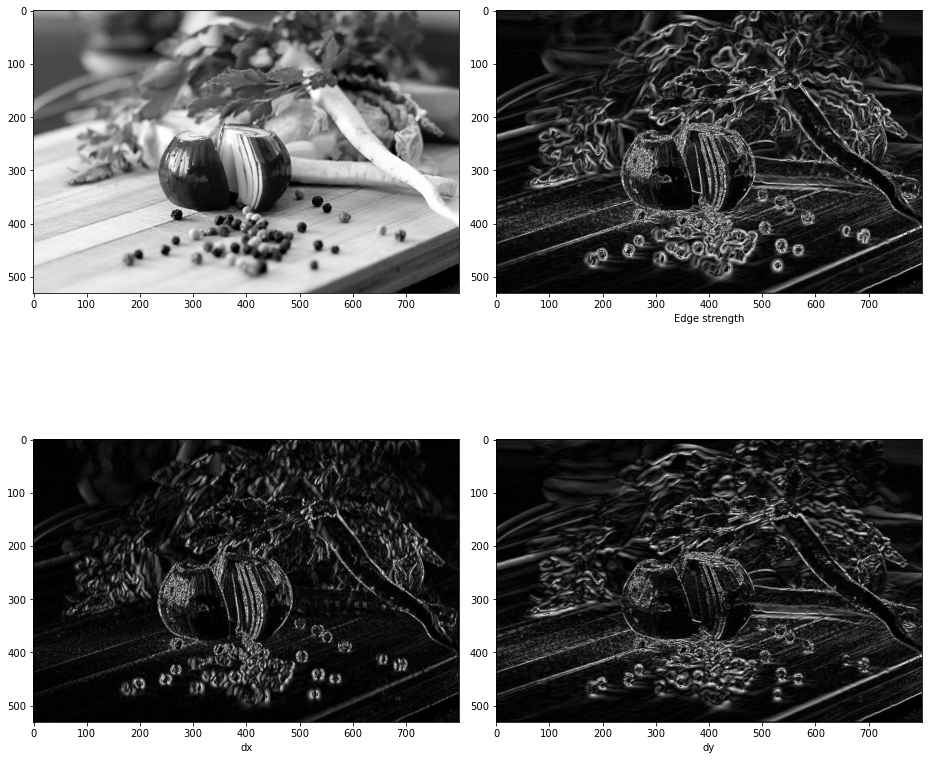

In [4]:
fig = plt.figure(figsize=(13,13))

plt.subplot(221)
plt.imshow(img,cmap='gray')

plt.subplot(222)
plt.imshow(S,cmap='gray')
plt.xlabel('Edge strength')

plt.subplot(223)
plt.imshow(np.uint8(abs(dx_image)),cmap='gray') # 변화량은 음수값도 나오기 때문에 절대값 연산을 해야한다.
plt.xlabel('dx')

plt.subplot(224)
plt.imshow(np.uint8(abs(dy_image)),cmap='gray')
plt.xlabel('dy')

fig.tight_layout()
plt.show()

### OpenCV
opencv에서는 소벨연산을 하는 함수자체가 따로 제공된다. 소벨 연산이 필요한 경우 cv2.Sobel 함수를 사용하면 된다.

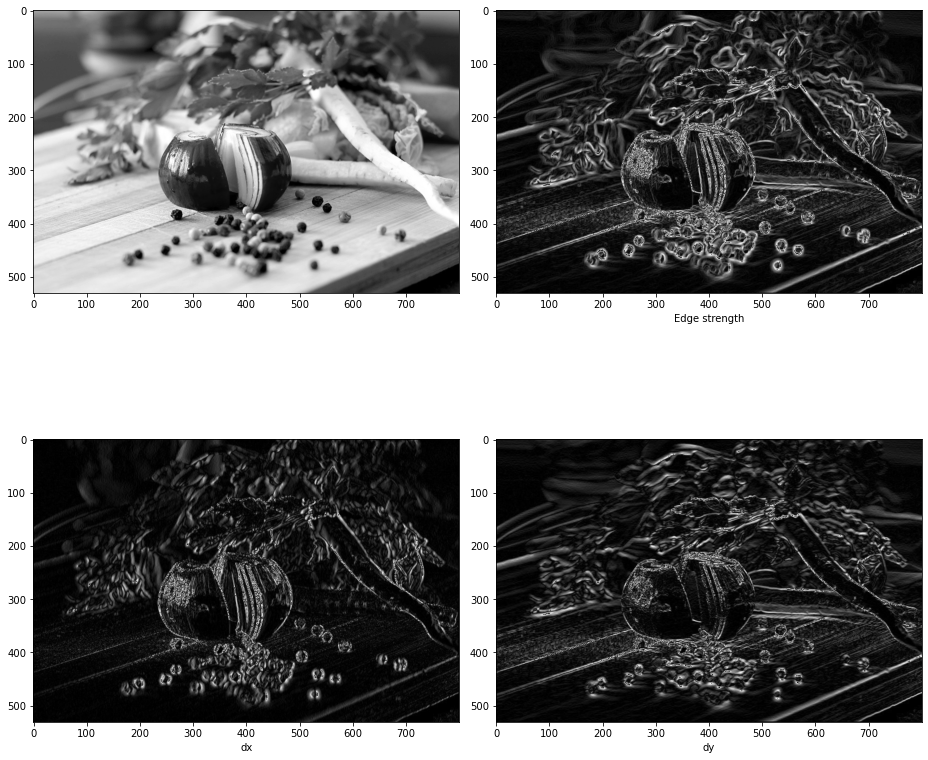

In [5]:
cv_sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1)
cv_sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0)
cv_s = np.uint8(np.sqrt((cv_sobel_x**2)+(cv_sobel_y**2)))

fig = plt.figure(figsize=(13,13))

plt.subplot(221)
plt.imshow(img,cmap='gray')

plt.subplot(222)
plt.imshow(cv_s,cmap='gray')
plt.xlabel('Edge strength')

plt.subplot(223)
plt.imshow(np.uint8(abs(cv_sobel_x)),cmap='gray')
plt.xlabel('dx')

plt.subplot(224)
plt.imshow(np.uint8(abs(cv_sobel_y)),cmap='gray')
plt.xlabel('dy')

fig.tight_layout()
plt.show()